Sample: one_nf1
Integrated intensity for each peak:
[7631.4734785641895, 4214.287556599076]
Branching ratio, B = 0.6442366561262485
n_peaks(peak intensity, location): 
[[8.90985155e+02 5.81446695e-01]
 [8.43527521e+02 9.96511334e-01]]


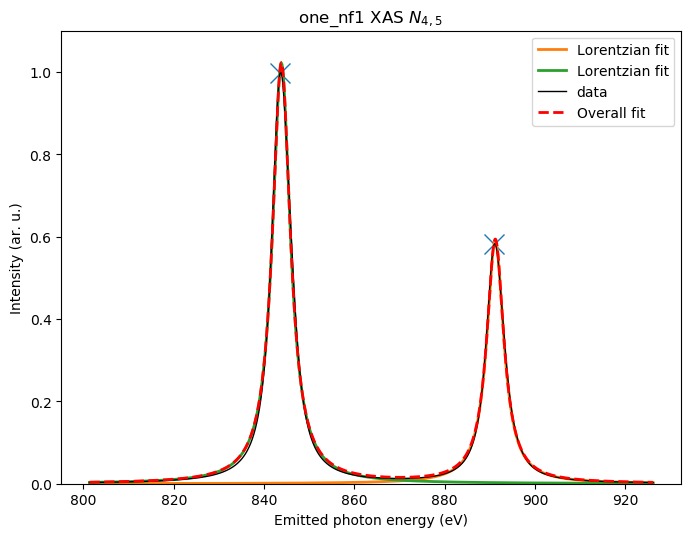

Sample: one_nf2
Integrated intensity for each peak:
[7956.777119199267, 3570.5042859734212]
Branching ratio, B = 0.6902561705163879
n_peaks(peak intensity, location): 
[[8.90502254e+02 4.63617069e-01]
 [8.43155884e+02 9.89581544e-01]]


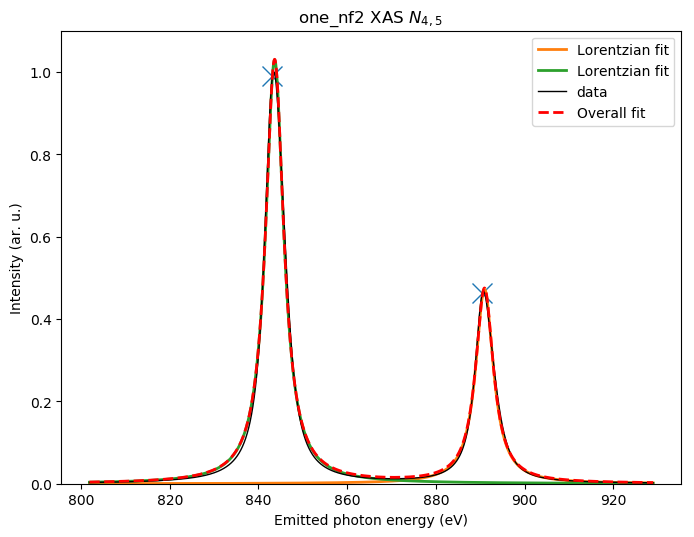

Sample: one_nf3
Integrated intensity for each peak:
[7797.364499247726, 2820.855864481771]
Branching ratio, B = 0.7343381689348377
n_peaks(peak intensity, location): 
[[8.90847623e+02 3.69201389e-01]
 [8.43464540e+02 9.95424372e-01]]


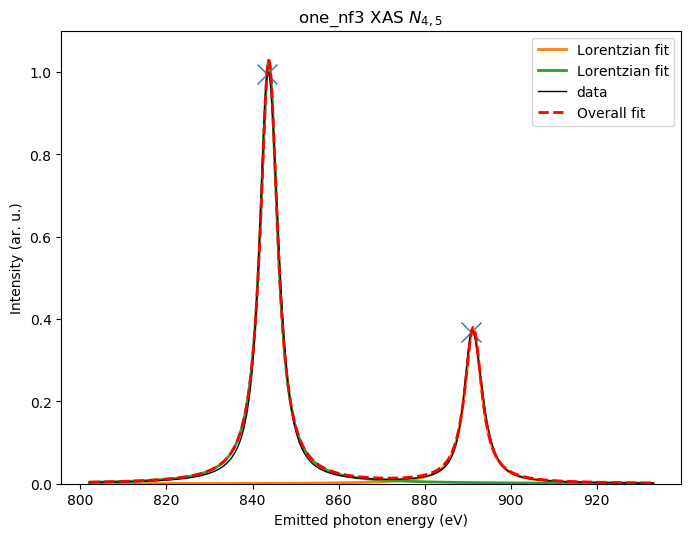

Sample: one_nf4
Integrated intensity for each peak:
[7837.8538142050065, 2313.8198398210716]
Branching ratio, B = 0.7720750372128611
n_peaks(peak intensity, location): 
[[8.91235593e+02 2.95529976e-01]
 [8.43641447e+02 9.98817123e-01]]


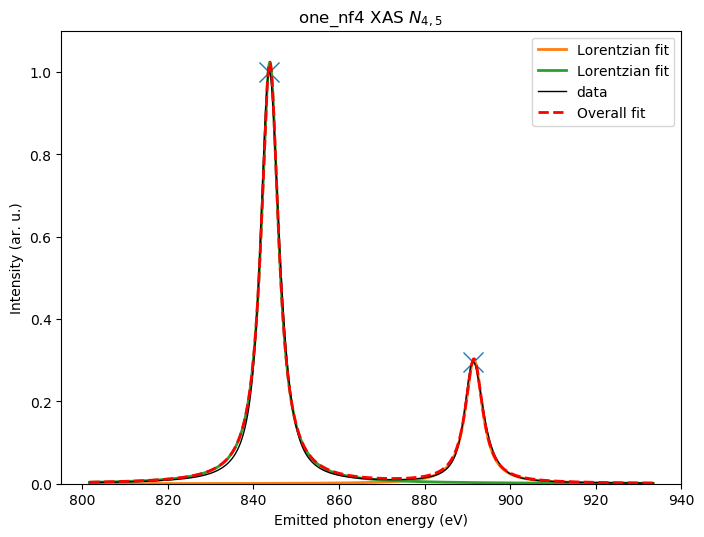

Sample: one_nf5
Integrated intensity for each peak:
[8199.211122692612, 1686.7281557407746]
Branching ratio, B = 0.8293810928597906
n_peaks(peak intensity, location): 
[[8.90333921e+02 1.84130803e-01]
 [8.43451045e+02 9.99133085e-01]]


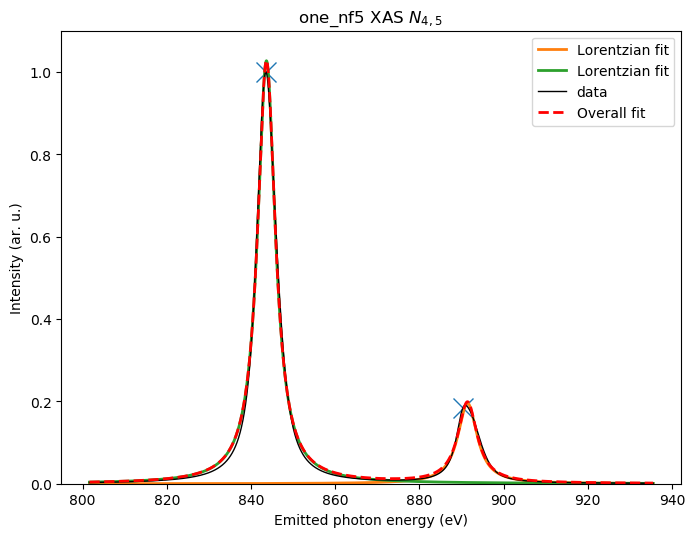

Sample: one_nf6
Integrated intensity for each peak:
[8060.012793726337, 663.8945220596381]
Branching ratio, B = 0.923899406764866
n_peaks(peak intensity, location): 
[[8.92026379e+02 9.35297528e-02]
 [8.42925173e+02 9.99794383e-01]]


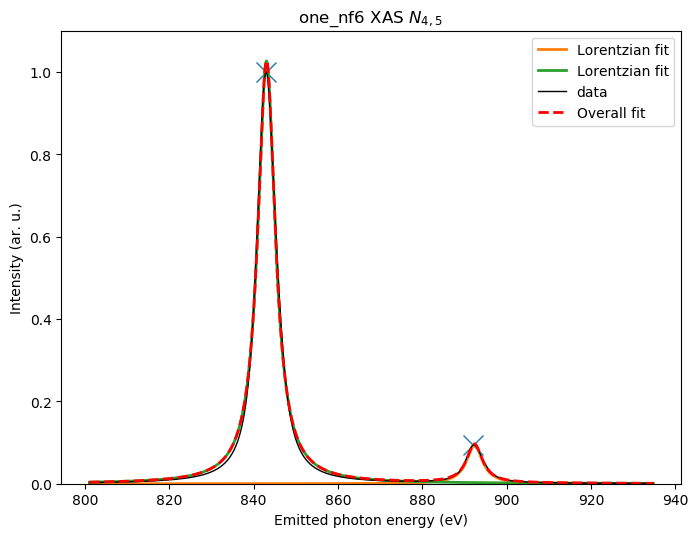

Sample: one_nf7
Integrated intensity for each peak:
[7297.574551922016, 2476.677152303737]
Branching ratio, B = 0.7466120960203039
n_peaks(peak intensity, location): 
[[8.91843544e+02 3.63916294e-01]
 [8.43494402e+02 9.97296046e-01]]


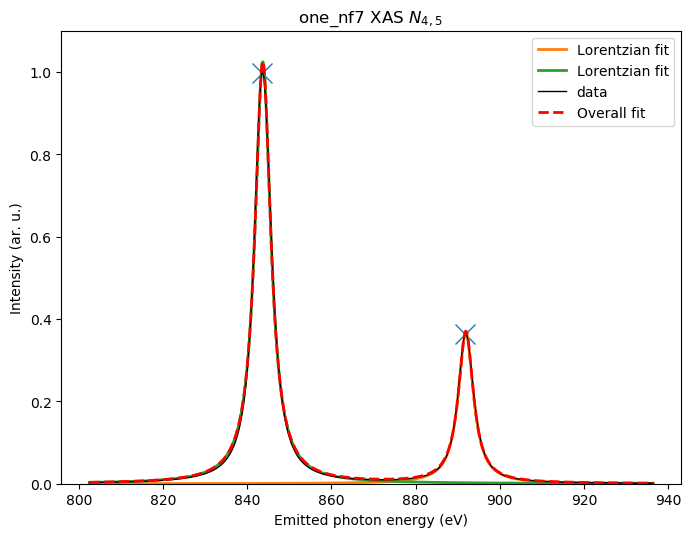

Sample: MPI_n4p5
Integrated intensity for each peak:
[7108.678203411762, 1309.539996578209]
Branching ratio, B = 0.8444397655812997
n_peaks(peak intensity, location): 
[[9.04281860e+02 1.82871592e-01]
 [8.56233267e+02 9.94195258e-01]]


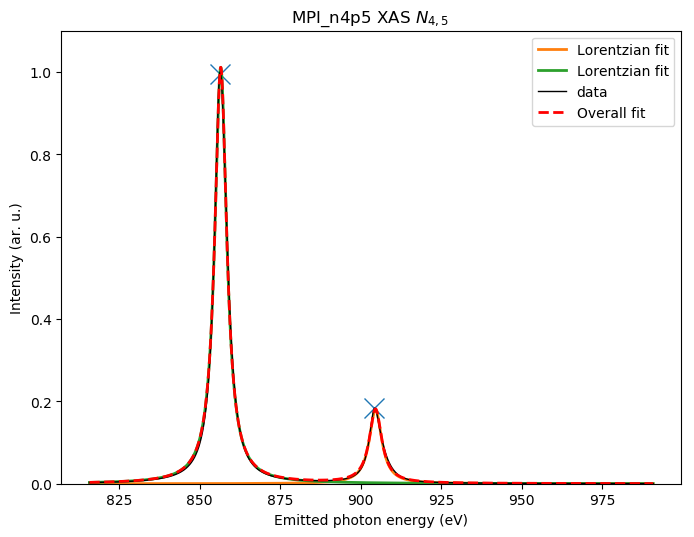

Sample: MPI_n5
Integrated intensity for each peak:
[7084.999280400444, 1143.2460857566841]
Branching ratio, B = 0.8610583380924846
n_peaks(peak intensity, location): 
[[9.05279925e+02 1.59181215e-01]
 [8.57012409e+02 9.94681542e-01]]


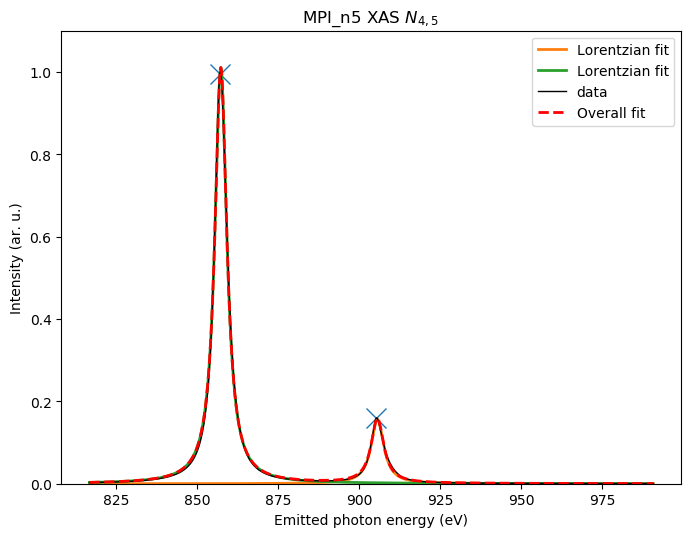

Sample: MPI_n5p5
Integrated intensity for each peak:
[7046.346086434718, 950.1457283994404]
Branching ratio, B = 0.8811796784889042
n_peaks(peak intensity, location): 
[[9.06535079e+02 1.33394704e-01]
 [8.57873376e+02 9.95045591e-01]]


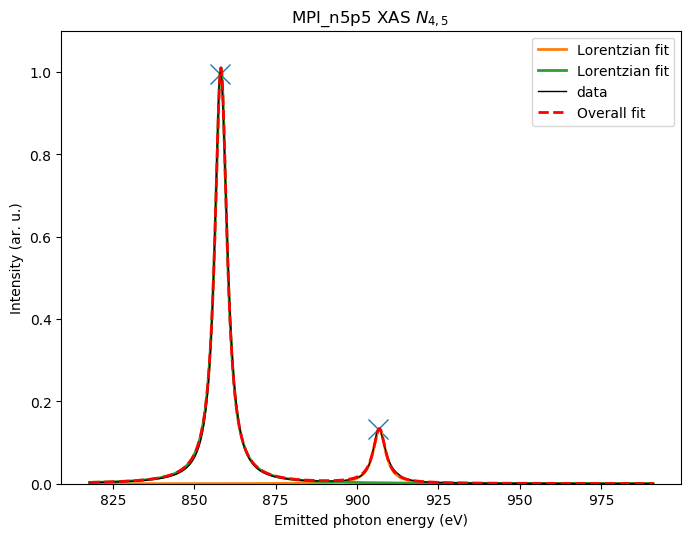

Finished!


In [24]:
%matplotlib inline
import glob, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy.signal
from scipy.optimize import curve_fit
import peakutils
import math
import traceback
from collections import OrderedDict 

num_peaks = 2

folder_list_3 = ['Lorentzian_fitting']

samples_to_analyse = ['one_nf1', 'one_nf2', 'one_nf3', 'one_nf4', 'one_nf5', 'one_nf6', 'one_nf7', 'MPI_n4p5', 'MPI_n5', 'MPI_n5p5']

path_to_folder = "./"

file = open(path_to_folder+"intensity.txt","w+")

def import_data(samples_to_analyse, path_to_folder=path_to_folder):
    dict_container = OrderedDict()
    for sample_id in samples_to_analyse:
        dict_container[sample_id] = []
    #print(dict_container)

    for sample_id in samples_to_analyse:
        path = path_to_folder + "XAS_intensity_" + sample_id + ".txt"

        #print(path)
        for filepath in glob.glob(path):
            #print(filepath)
            data_from_file = np.genfromtxt(filepath)
            dict_container[sample_id].append(data_from_file)
    return dict_container

def lorentzian(x, amp, ctr, wid):
    return amp*wid**2/((x-ctr)**2+wid**2)

def func(x, *params):
    ''' *params of the form [center, amplitude, width ...] '''
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + lorentzian(x, amp, ctr, wid)
    return y

## Uses scipy curve_fit to optimise the lorentzian fitting
def fit_lorentzians(guess, func, x, y):
    popt, pcov = curve_fit(func, x, y, p0=guess, maxfev=14000)#, sigma=2)
    #print('popt:', popt)
    fit = func(x, *popt)
    return (popt, fit)

def remove_baseline(xs, ys, return_xs=False, degree=5): ##Returns just ys unless otherwise specified
    ###Remove baseline with polynomial
    y2 = ys + np.polyval([0.001,-0.08,degree], xs)
    # y2 = ys
    base = peakutils.baseline(y2, 2)
    if return_xs:
        return (xs, y2-base)
    else:
        return y2-base

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#Not perfect but seems to find the most obscure ones, I use this one
def find_peaks_scipy(xs, ys, widths=np.arange(1,100, 0.5)):
    peaks = scipy.signal.find_peaks_cwt(ys, widths)#Problem
    #print('*************PEAKSCIPY**************')
    #print('From scipy: \nPeak_pos= ', peaks, '\nPeaks= ', xs[peaks], '\nIntensities= ',ys[peaks])
    #print('************************************')

    return peaks 


## Returns the highest peaks found by the peak finding algorithms
def get_highest_n_from_list(a, n):
    return sorted(a, key=lambda pair: pair[1])[-n:]


def get_highest_n_peaks_scipy(xs, ys, n, th=0.15):
    smooth_indexes_scipy = find_peaks_scipy(xs, ys)
    ##take the highest 'n' smooth peaks 
    peak_indexes_xs_ys = np.asarray([list(a) for a in list(zip(xs[smooth_indexes_scipy], ys[smooth_indexes_scipy]))])
    return get_highest_n_from_list(peak_indexes_xs_ys, n)


def predict_and_plot_lorentzians(xs, ys, n_peaks_to_find):
    n_peaks = np.asarray(get_highest_n_peaks_scipy(xs, ys, n_peaks_to_find))

    plt.plot(n_peaks[:,0], n_peaks[:,1], ls='', marker='x', markersize=15) ##This is plotting the peak positions, the xs

    #print(n_peaks)
    guess = []

    for idx, xs_ys in enumerate(n_peaks):
        guess.append(xs_ys[0]) #ctr
        guess.append(xs_ys[1]) #amp
        guess.append(5) #width ###This could be improved by estimating the width first for a better fit
    #print('Fit Guess: ', guess)
    
    params, fit = fit_lorentzians(guess, func, xs, ys) ###params is the array of gaussian stuff, fit is the y's of lorentzians

    return (params, fit, ys, n_peaks)

## The following code runs through each repeated measurement from all of the samples
# and attempts to fit lorentzians to the data.
def main_predict_fit():

    dict_container = import_data(samples_to_analyse) #global variable at present

    ###THIS CODE GOES THROUGH ALL THE DATA 
    for sample_id, sample_data in dict_container.items():#21, 22 etc
        # print(sample_data)
        for idx, data_set in enumerate(sample_data):
            xs = data_set[:,0]
            ys = data_set[:,1]
            #data_set[:,1] = remove_baseline(xs, data_set[:,1])
            data_set[:,1] = data_set[:,1]/np.max(data_set[:,1])
            plt.figure(figsize=(8, 6), dpi = 100)
            plt.title(sample_id + " XAS $N_{4,5}$ ")

            try:
                print("Sample: "+sample_id)
                params, fit, ys, n_peaks = predict_and_plot_lorentzians(xs,ys, num_peaks) #5 = number of peaks to fit to ##Returns modified ys for y axis scaling
                file.write(sample_id+"\t")
                intensity = find_intensity(params)
                print("Integrated intensity for each peak:")
                print(intensity)
                B = intensity[0]/sum(intensity)
                print("Branching ratio, B = " + str(B) )
                for j in range(0, len(params), 3): 
                    ctr = params[j] 
                    amp = params[j+1]
                    width = params[j+2]
                    plt.plot(xs, lorentzian(xs, amp, ctr, width), ls='-' , lw=2, label = 'Lorentzian fit')
                    file.write(str(amp)+"\t")
                file.write("\n")
                plt.plot(xs,ys, lw=1, label='data', c='black')
                plt.plot(xs, fit, 'r-', label='Overall fit', c='red', lw=2, ls='--')
                plt.legend()
                plt.ylim([0,1.1])
                #plt.xlim([250,450])
                plt.ylabel("Intensity (ar. u.)")
                plt.xlabel("Emitted photon energy (eV)")

            except RuntimeError:
                print(traceback.format_exc())
                plt.plot(xs,ys, lw=1, label='data- no fit found', c='black')

                plt.legend()
                plt.ylabel("Intensity (ar. u.)")
                plt.xlabel("Emitted photon energy (eV)")
                
            print('n_peaks(peak intensity, location): ')
            print(n_peaks)
            
        plt.show()
    file.close()

def find_intensity(params):
    intensity_list = []
    for j in range(0, len(params), 3):
        intensity = 0
        ctr = params[j] 
        amp = params[j+1]
        width = params[j+2]
        x = np.linspace(ctr-100, ctr+100, 200000)
        for i in range(len(x)):
            intensity += lorentzian(x[i], amp, ctr, width)
        intensity_list.append(intensity)
    intensity_list.sort(reverse=True)
    return intensity_list
    
def calculate_SPI():
    file1 = np.genfromtxt(path_to_folder+"intensity.txt")
    file2 = open(path_to_folder+"SPI.txt","w+")
    for i in range(0, len(file1)):
        file2.write(str(file1[i,0]) + "\t" + str(file1[i,1]/file1[i,2]) +"\n")
    file2.close()

if __name__ == "__main__":
    main_predict_fit()
    #calculate_SPI()
    print("Finished!")